# Assignment 3: Building a Decision Tree After Feature Transformations

In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


In this assignment, you will implement the following steps to build a Decision Tree classification model:

1. Load the "cell2celltrain" data set
2. Convert categorical features to one-hot encoded values
3. Split the data into training and test sets
4. Fit a Decision Tree classifier and evaluate the accuracy of its predictions
5. Plot the training set accuracy

## Part 1. Load the Data Set

We will work with the "cell2celltrain" data set.

In [2]:
# Do not remove or edit the line below:
filename = os.path.join(os.getcwd(), "data", "cell2celltrain.csv")

**Task**: Load the data and save it to DataFrame `df`.

In [3]:
df=pd.read_csv(filename)

**Task**: Display the shape of `df` -- that is, the number of records (rows) and variables (columns)

In [4]:
df.shape

(51047, 58)

 For the purpose of this assignment, we will remove the `Married` column due to missing values

In [5]:
df.drop(columns = ['Married'], inplace=True)
df

,CustomerID,Churn,ServiceArea,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,HomeownershipKnown,BuysViaMailOrder,...,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,RetentionCalls,RetentionOffersAccepted,ReferralsMadeBySubscriber,IncomeGroup,AdjustmentsToCreditRating,HandsetPrice
0,3000002,True,SEAPOR503,False,False,True,False,False,True,True,...,0.487071,-0.077013,1.387766,-0.883541,4.662897,-0.128300,-0.169283,-0.103411,-0.140707,-0.864858
1,3000010,True,PITHOM412,True,False,False,False,False,True,True,...,-0.616775,3.019920,0.392039,0.871495,-0.180167,-0.128300,-0.169283,0.215243,-0.140707,-0.864858
2,3000014,False,MILMIL414,True,False,False,False,False,False,False,...,-0.616775,3.019920,-0.241605,0.202910,-0.180167,-0.128300,-0.169283,0.533896,-0.140707,-0.368174
3,3000022,False,PITHOM412,False,False,True,False,False,True,True,...,2.694763,0.305179,-0.060564,-0.883541,-0.180167,-0.128300,-0.169283,0.533896,-0.140707,-1.195980
4,3000026,True,OKCTUL918,False,False,False,False,False,True,True,...,1.590917,1.857585,0.663601,1.372934,-0.180167,-0.128300,-0.169283,1.489856,2.469282,-1.195980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51042,3399958,True,LAXSFN818,False,True,True,False,False,True,True,...,0.487071,0.573107,1.659328,1.790800,-0.180167,-0.128300,-0.169283,0.533896,-0.140707,-0.368174
51043,3399974,False,LAXCDG310,True,False,True,False,False,True,True,...,0.487071,0.328819,0.754122,1.122214,-0.180167,-0.128300,-0.169283,1.489856,2.469282,-0.368174
51044,3399978,True,LAXCDG310,False,False,True,False,False,True,False,...,0.487071,-0.010031,0.210998,-0.883541,-0.180167,-0.128300,-0.169283,0.852549,2.469282,-0.037051
51045,3399990,False,NEVPOW619,True,False,True,False,False,False,False,...,0.487071,0.206676,0.029957,-0.883541,-0.180167,-0.128300,-0.169283,1.489856,-0.140707,-0.864858


## Part 2. One-Hot Encode Categorical Values


To implement a decision tree model, we must first transform the string-valued categorical features into numerical boolean values using one-hot encoding.

### a. Find the Columns Containing String Values

In [6]:
df.dtypes

CustomerID                     int64
Churn                           bool
ServiceArea                   object
ChildrenInHH                    bool
HandsetRefurbished              bool
HandsetWebCapable               bool
TruckOwner                      bool
RVOwner                         bool
HomeownershipKnown              bool
BuysViaMailOrder                bool
RespondsToMailOffers            bool
OptOutMailings                  bool
NonUSTravel                     bool
OwnsComputer                    bool
HasCreditCard                   bool
NewCellphoneUser                bool
NotNewCellphoneUser             bool
OwnsMotorcycle                  bool
MadeCallToRetentionTeam         bool
CreditRating                  object
PrizmCode                     object
Occupation                    object
MonthlyRevenue               float64
MonthlyMinutes               float64
TotalRecurringCharge         float64
DirectorAssistedCalls        float64
OverageMinutes               float64
R

**Task**: Add all of the column names whos values are of type 'object' to a list named `to_encode`.

In [33]:
to_encode = []
for i in df.columns:
    if df[i].dtype == 'object' :
        to_encode.append(i)

print(to_encode)

#to_encode = list(df.selct_dtypes(indclude=['object']).columns)


['ServiceArea', 'CreditRating', 'PrizmCode', 'Occupation']

Let's take a closer look at the candidates for one-hot encoding:

In [34]:
df[to_encode].nunique()

ServiceArea     747
CreditRating      7
PrizmCode         4
Occupation        8
dtype: int64

For all of the columns except for `ServiceArea`, it should be straightforward to replace a given column with a set of several new binary columns for each unique value. However, let's first deal with the special case of `ServiceArea`.

### b. One Hot-Encoding 'ServiceArea': The Top 10 Values

Take a look at the number of unique values of the `ServiceArea` column. There are two many unique values in the `ServiceArea` column to attempt to create a new binary indicator column per value! 
One thing we could do is to see if some of the values in `ServiceArea` are occurring frequently. We will then one-hot encode just those frequent values.

<b>Task</b>: Get the top 10 most frequent values in 'ServiceArea' and store them in list `top_10_SA`.

In [37]:
top_10_SA = df['ServiceArea'].value_counts().head(10).index.tolist()
#sort_values(ascending=True) 
#not working because it will be sorted in # then list 10
top_10_SA

#top_10_SA = list(df['ServiceArea'].value_counts().head(10).index)

['NYCBRO917',
 'HOUHOU281',
 'DALDAL214',
 'NYCMAN917',
 'APCFCH703',
 'DALFTW817',
 'SANSAN210',
 'APCSIL301',
 'SANAUS512',
 'SFROAK510']

<b>Task</b>: Write a `for` loop that loops through every value in `top_10_SA` and creates one-hot encoded columns, titled <br>'ServiceArea + '\_' + $<$service area value$>$'. For example, there will be a column named  'ServiceArea\_NYCBRO917'. Use the NumPy `np.where()`function  to accomplish this.

In [39]:
#titles = []
for v in top_10_SA:
    #titles.append('ServiceArea_'+v)
    #INVALID, need to append True 1, False 0 
    df['ServiceArea_'+v]=np.where(df['ServiceArea']==v,1,0)
df

,CustomerID,Churn,ServiceArea,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,HomeownershipKnown,BuysViaMailOrder,...,ServiceArea_NYCBRO917,ServiceArea_HOUHOU281,ServiceArea_DALDAL214,ServiceArea_NYCMAN917,ServiceArea_APCFCH703,ServiceArea_DALFTW817,ServiceArea_SANSAN210,ServiceArea_APCSIL301,ServiceArea_SANAUS512,ServiceArea_SFROAK510
0,3000002,True,SEAPOR503,False,False,True,False,False,True,True,...,0,0,0,0,0,0,0,0,0,0
1,3000010,True,PITHOM412,True,False,False,False,False,True,True,...,0,0,0,0,0,0,0,0,0,0
2,3000014,False,MILMIL414,True,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,3000022,False,PITHOM412,False,False,True,False,False,True,True,...,0,0,0,0,0,0,0,0,0,0
4,3000026,True,OKCTUL918,False,False,False,False,False,True,True,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51042,3399958,True,LAXSFN818,False,True,True,False,False,True,True,...,0,0,0,0,0,0,0,0,0,0
51043,3399974,False,LAXCDG310,True,False,True,False,False,True,True,...,0,0,0,0,0,0,0,0,0,0
51044,3399978,True,LAXCDG310,False,False,True,False,False,True,False,...,0,0,0,0,0,0,0,0,0,0
51045,3399990,False,NEVPOW619,True,False,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0


<b>Task</b>: 
1. Drop the original, multi-valued `ServiceArea` column from the DataFrame `df`. 
2. Remove 'ServiceArea' from the `to_encode` list.

In [43]:
df.drop(columns = ['ServiceArea'], inplace=True)
to_encode.remove('ServiceArea')
to_encode

['CreditRating', 'PrizmCode', 'Occupation']

In [44]:
df.head()

,CustomerID,Churn,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,HomeownershipKnown,BuysViaMailOrder,RespondsToMailOffers,...,ServiceArea_NYCBRO917,ServiceArea_HOUHOU281,ServiceArea_DALDAL214,ServiceArea_NYCMAN917,ServiceArea_APCFCH703,ServiceArea_DALFTW817,ServiceArea_SANSAN210,ServiceArea_APCSIL301,ServiceArea_SANAUS512,ServiceArea_SFROAK510
0,3000002,True,False,False,True,False,False,True,True,True,...,0,0,0,0,0,0,0,0,0,0
1,3000010,True,True,False,False,False,False,True,True,True,...,0,0,0,0,0,0,0,0,0,0
2,3000014,False,True,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,3000022,False,False,False,True,False,False,True,True,True,...,0,0,0,0,0,0,0,0,0,0
4,3000026,True,False,False,False,False,False,True,True,True,...,0,0,0,0,0,0,0,0,0,0


### c. One Hot-Encoding all Remaining Columns: All Unique Values per Column

All other columns in `to_encode` have reasonably small numbers of unique values, so we are going to simply one-hot encode every unique value of those columns.

<b>Task</b>: In the code cell below, iterate over column names and create new columns for all unique values.
1. Use a loop to loop over the column names in `to_encode` 
2. In the loop:
    1. Use the Pandas `pd.get_dummies()` function and save the result to variable `temp_df`
    2. Use `df.join` to join `temp_df` with DataFrame `df`


In [50]:
for colname in to_encode:
    temp_df = pd.get_dummies(df[colname],prefix=colname +'_')
    df=df.join(temp_df)
df    

,CustomerID,Churn,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,HomeownershipKnown,BuysViaMailOrder,RespondsToMailOffers,...,PrizmCode_Suburban,PrizmCode_Town,Occupation_Clerical,Occupation_Crafts,Occupation_Homemaker,Occupation_Other,Occupation_Professional,Occupation_Retired,Occupation_Self,Occupation_Student
0,3000002,True,False,False,True,False,False,True,True,True,...,1,0,0,0,0,0,1,0,0,0
1,3000010,True,True,False,False,False,False,True,True,True,...,1,0,0,0,0,0,1,0,0,0
2,3000014,False,True,False,False,False,False,False,False,False,...,0,1,0,1,0,0,0,0,0,0
3,3000022,False,False,False,True,False,False,True,True,True,...,0,0,0,0,0,1,0,0,0,0
4,3000026,True,False,False,False,False,False,True,True,True,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51042,3399958,True,False,True,True,False,False,True,True,True,...,1,0,0,0,0,1,0,0,0,0
51043,3399974,False,True,False,True,False,False,True,True,True,...,0,0,0,0,0,1,0,0,0,0
51044,3399978,True,False,False,True,False,False,True,False,False,...,0,0,1,0,0,0,0,0,0,0
51045,3399990,False,True,False,True,False,False,False,False,False,...,0,0,0,0,0,1,0,0,0,0


In [51]:
df.head()

,CustomerID,Churn,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,HomeownershipKnown,BuysViaMailOrder,RespondsToMailOffers,...,PrizmCode_Suburban,PrizmCode_Town,Occupation_Clerical,Occupation_Crafts,Occupation_Homemaker,Occupation_Other,Occupation_Professional,Occupation_Retired,Occupation_Self,Occupation_Student
0,3000002,True,False,False,True,False,False,True,True,True,...,1,0,0,0,0,0,1,0,0,0
1,3000010,True,True,False,False,False,False,True,True,True,...,1,0,0,0,0,0,1,0,0,0
2,3000014,False,True,False,False,False,False,False,False,False,...,0,1,0,1,0,0,0,0,0,0
3,3000022,False,False,False,True,False,False,True,True,True,...,0,0,0,0,0,1,0,0,0,0
4,3000026,True,False,False,False,False,False,True,True,True,...,0,0,0,0,0,0,1,0,0,0


<b>Task</b>: Remove all the original columns from DataFrame `df`

In [53]:
# remove to_encode columns from df
df= df.drop(to_encode,axis=1)
#df= df.drop(to_encode,axis=1, inplace = True)

In [54]:
df.columns

Index(['CustomerID', 'Churn', 'ChildrenInHH', 'HandsetRefurbished',
       'HandsetWebCapable', 'TruckOwner', 'RVOwner', 'HomeownershipKnown',
       'BuysViaMailOrder', 'RespondsToMailOffers', 'OptOutMailings',
       'NonUSTravel', 'OwnsComputer', 'HasCreditCard', 'NewCellphoneUser',
       'NotNewCellphoneUser', 'OwnsMotorcycle', 'MadeCallToRetentionTeam',
       'MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge',
       'DirectorAssistedCalls', 'OverageMinutes', 'RoamingCalls',
       'PercChangeMinutes', 'PercChangeRevenues', 'DroppedCalls',
       'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls', 'ThreewayCalls',
       'ReceivedCalls', 'OutboundCalls', 'InboundCalls', 'PeakCallsInOut',
       'OffPeakCallsInOut', 'DroppedBlockedCalls', 'CallForwardingCalls',
       'CallWaitingCalls', 'MonthsInService', 'UniqueSubs', 'ActiveSubs',
       'Handsets', 'HandsetModels', 'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2',
       'RetentionCalls', 'RetentionOffersAccepted',
    

Check that the data does not contain any missing values. The absense of missing values is necessary for training a Decision Tree model.

In [58]:
df.isnull().any().any()
#df.isna()
# search all col--> row 

False

## Part 3: Create Labeled Examples from the Data Set 

<b>Task</b>: Create labeled examples from DataFrame `df`. 
In the code cell below carry out the following steps:

* Get the `Churn` column from DataFrame `df` and assign it to the variable `y`. This will be our label.
* Get all other columns from DataFrame `df` and assign them to the variable `X`. These will be our features. 

In [71]:
y=df['Churn']
X=df.drop('Churn',axis=1)
X

,CustomerID,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,HomeownershipKnown,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,...,PrizmCode_Suburban,PrizmCode_Town,Occupation_Clerical,Occupation_Crafts,Occupation_Homemaker,Occupation_Other,Occupation_Professional,Occupation_Retired,Occupation_Self,Occupation_Student
0,3000002,False,False,True,False,False,True,True,True,False,...,1,0,0,0,0,0,1,0,0,0
1,3000010,True,False,False,False,False,True,True,True,False,...,1,0,0,0,0,0,1,0,0,0
2,3000014,True,False,False,False,False,False,False,False,False,...,0,1,0,1,0,0,0,0,0,0
3,3000022,False,False,True,False,False,True,True,True,False,...,0,0,0,0,0,1,0,0,0,0
4,3000026,False,False,False,False,False,True,True,True,False,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51042,3399958,False,True,True,False,False,True,True,True,False,...,1,0,0,0,0,1,0,0,0,0
51043,3399974,True,False,True,False,False,True,True,True,False,...,0,0,0,0,0,1,0,0,0,0
51044,3399978,False,False,True,False,False,True,False,False,False,...,0,0,1,0,0,0,0,0,0,0
51045,3399990,True,False,True,False,False,False,False,False,False,...,0,0,0,0,0,1,0,0,0,0


## Part 4:  Create Training and Test Data Sets

<b>Task</b>: In the code cell below create training and test sets out of the labeled examples. 

1. Use Scikit-learn's `train_test_split()` function to create the data sets.

2. Specify:
    * A test set that is 30 percent (.30) of the size of the data set.
    * A seed value of '123'. 
    


In [72]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3, random_state=123)

Check that the dimensions of the training and test datasets are what you expected:

In [70]:
print(X_train.shape)
print(X_test.shape)

(35732, 92)
(15315, 92)


## Part 5. Fit a Decision Tree Classifer and Evaluate the Model

The code cell below contains a shell of a function named `train_test_DT()`. This function should train a Decision Tree classifier on the training data, test the resulting model on the test data, and compute and return the accuracy score of the resulting predicted class labels on the test data.

<b>Task:</b> Complete the function to make it work.

In [76]:
def train_test_DT(X_train, X_test, y_train, y_test, leaf, depth, crit='entropy'):
    '''
    Fit a Decision Tree classifier to the training data X_train, y_train.
    Return the accuracy of resulting predictions on the test set.
    Parameters:
        leaf := The minimum number of samples required to be at a leaf node 
        depth := The maximum depth of the tree
        crit := The function to be used to measure the quality of a split. Default: gini.
    '''
    
     # 1. Create the  Scikit-learn DecisionTreeClassifier model object below and assign to variable 'model'
    model= DecisionTreeClassifier(min_samples_leaf=leaf, max_depth=depth, criterion=crit)
  
    # 2. Fit the model to the training data below
    model.fit(X_train, y_train)
    
    # 3. Make predictions on the test data and assign the result to the variable 'class_label_predictions' below
    class_label_predictions=model.predict(X_test)
        
  
    # 4. Compute the accuracy and save the result to the variable 'acc_score' below
    acc_score = accuracy_score(y_test,class_label_predictions) 
    
    return acc_score

### Train on Different Hyperparameter Values

<b>Task:</b> Train two Decision Tree classifiers using your function. 

- one with a low value of depth
- one high value of depth

Specify the minimum number of samples at the leaf node to be equal to $1$ for both trees.

Save the resulting accuracy scores to list `acc`. Print the list.

In [80]:
depth1= 8
depth2 = 32
leaf = 1

max_depth_range = [depth1, depth2]
acc = []

for max_depth in max_depth_range:
    score = train_test_DT(X_train, X_test, y_train, y_test, 1, max_depth)
    #print('Max Depth=',max_depth,'Acc Score=',score)
    acc.append(score)
    
print(acc)

[0.710871694417238, 0.6208945478289258]


<b>Task</b>: Visualize the results (Hint: use a `seaborn` lineplot).

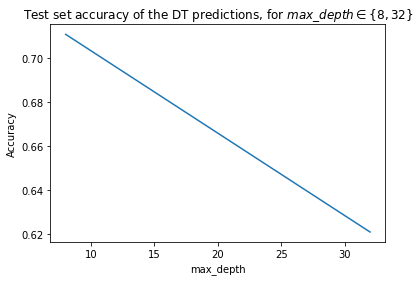

In [81]:
fig = plt.figure()
ax = fig.add_subplot(111)
p = sns.lineplot(x=max_depth_range, y=acc, marker='o', label = 'Full training Set')
plt.title('Test set accuracy of the DT predictions, for $max\_depth\in\{8, 32\}$')
ax.set_xlabel('max_depth')
ax.set_ylabel('Accuracy')
plt.show()

<b>Analysis</b>: Experiment with different values for `max_depth`. Add these values to the list `max_depth_range` (i.e. change the values, create a list containing more values), retrain your model and rerun with the visualization cell above. Compare the different accuracy scores.

Once you find the best value for `max_depth`, experiment with different values for `leaf` and compare the different accuracy scores.

Is there one model configuration that yields the best score? Record your findings in the cell below.

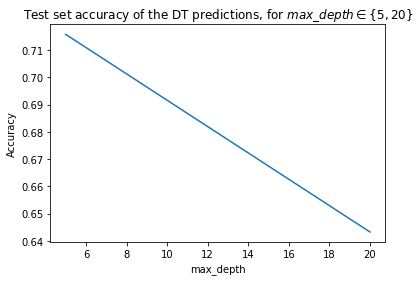

In [82]:
depth1= 5
depth2 = 20
leaf = 1

max_depth_range = [depth1, depth2]
acc = []

for max_depth in max_depth_range:
    score = train_test_DT(X_train, X_test, y_train, y_test, 1, max_depth)
    acc.append(score)
    
fig = plt.figure()
ax = fig.add_subplot(111)
p = sns.lineplot(x=max_depth_range, y=acc)

plt.title('Test set accuracy of the DT predictions, for $max\_depth\in\{5, 20\}$')
ax.set_xlabel('max_depth')
ax.set_ylabel('Accuracy')
plt.show()

## Analysis

I tried to find best match to yield better accuracy by adjusting max_depth and left range. After running modified code that I made and rerun the codes again, I found the fact that the highest accuracy scores would be the best result. But unfortunately, I did not find any remarkable result through this method. It was pretty hard to figure out the highes point from random numbers that I plugged in.

### Proper Analysis
Experiemnt with different values for max_depth.
Add these values to the list max_depth_range (i.e. change the values, create a list containing more values), retrain your model and rerun with the visualization cell above.

Compare the different accuracy scores.

Once you find the best value for max_depth, experiment with different values for leaf and compare the different accuracy scores.